In [5]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('UNLifeExpectancy.csv',
                 usecols=['ILLITERATE', 'POP', 'FERTILITY', 'PRIVATEHEALTH', 'HEALTHEXPEND',
                          'BIRTHATTEND', 'PHYSICIAN', 'GDP', 'LIFEEXP'])
X = df.iloc[:, 1:]
y = df[['LIFEEXP']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 9 columns):
LIFEEXP          185 non-null float64
ILLITERATE       171 non-null float64
POP              184 non-null float64
FERTILITY        181 non-null float64
PRIVATEHEALTH    184 non-null float64
HEALTHEXPEND     180 non-null float64
BIRTHATTEND      178 non-null float64
PHYSICIAN        182 non-null float64
GDP              178 non-null float64
dtypes: float64(9)
memory usage: 13.1 KB


In [4]:
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

/home/andrey/PycharmProjects/julia_lab/venv/lib/python3.8/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


сначала смотрим на данные:

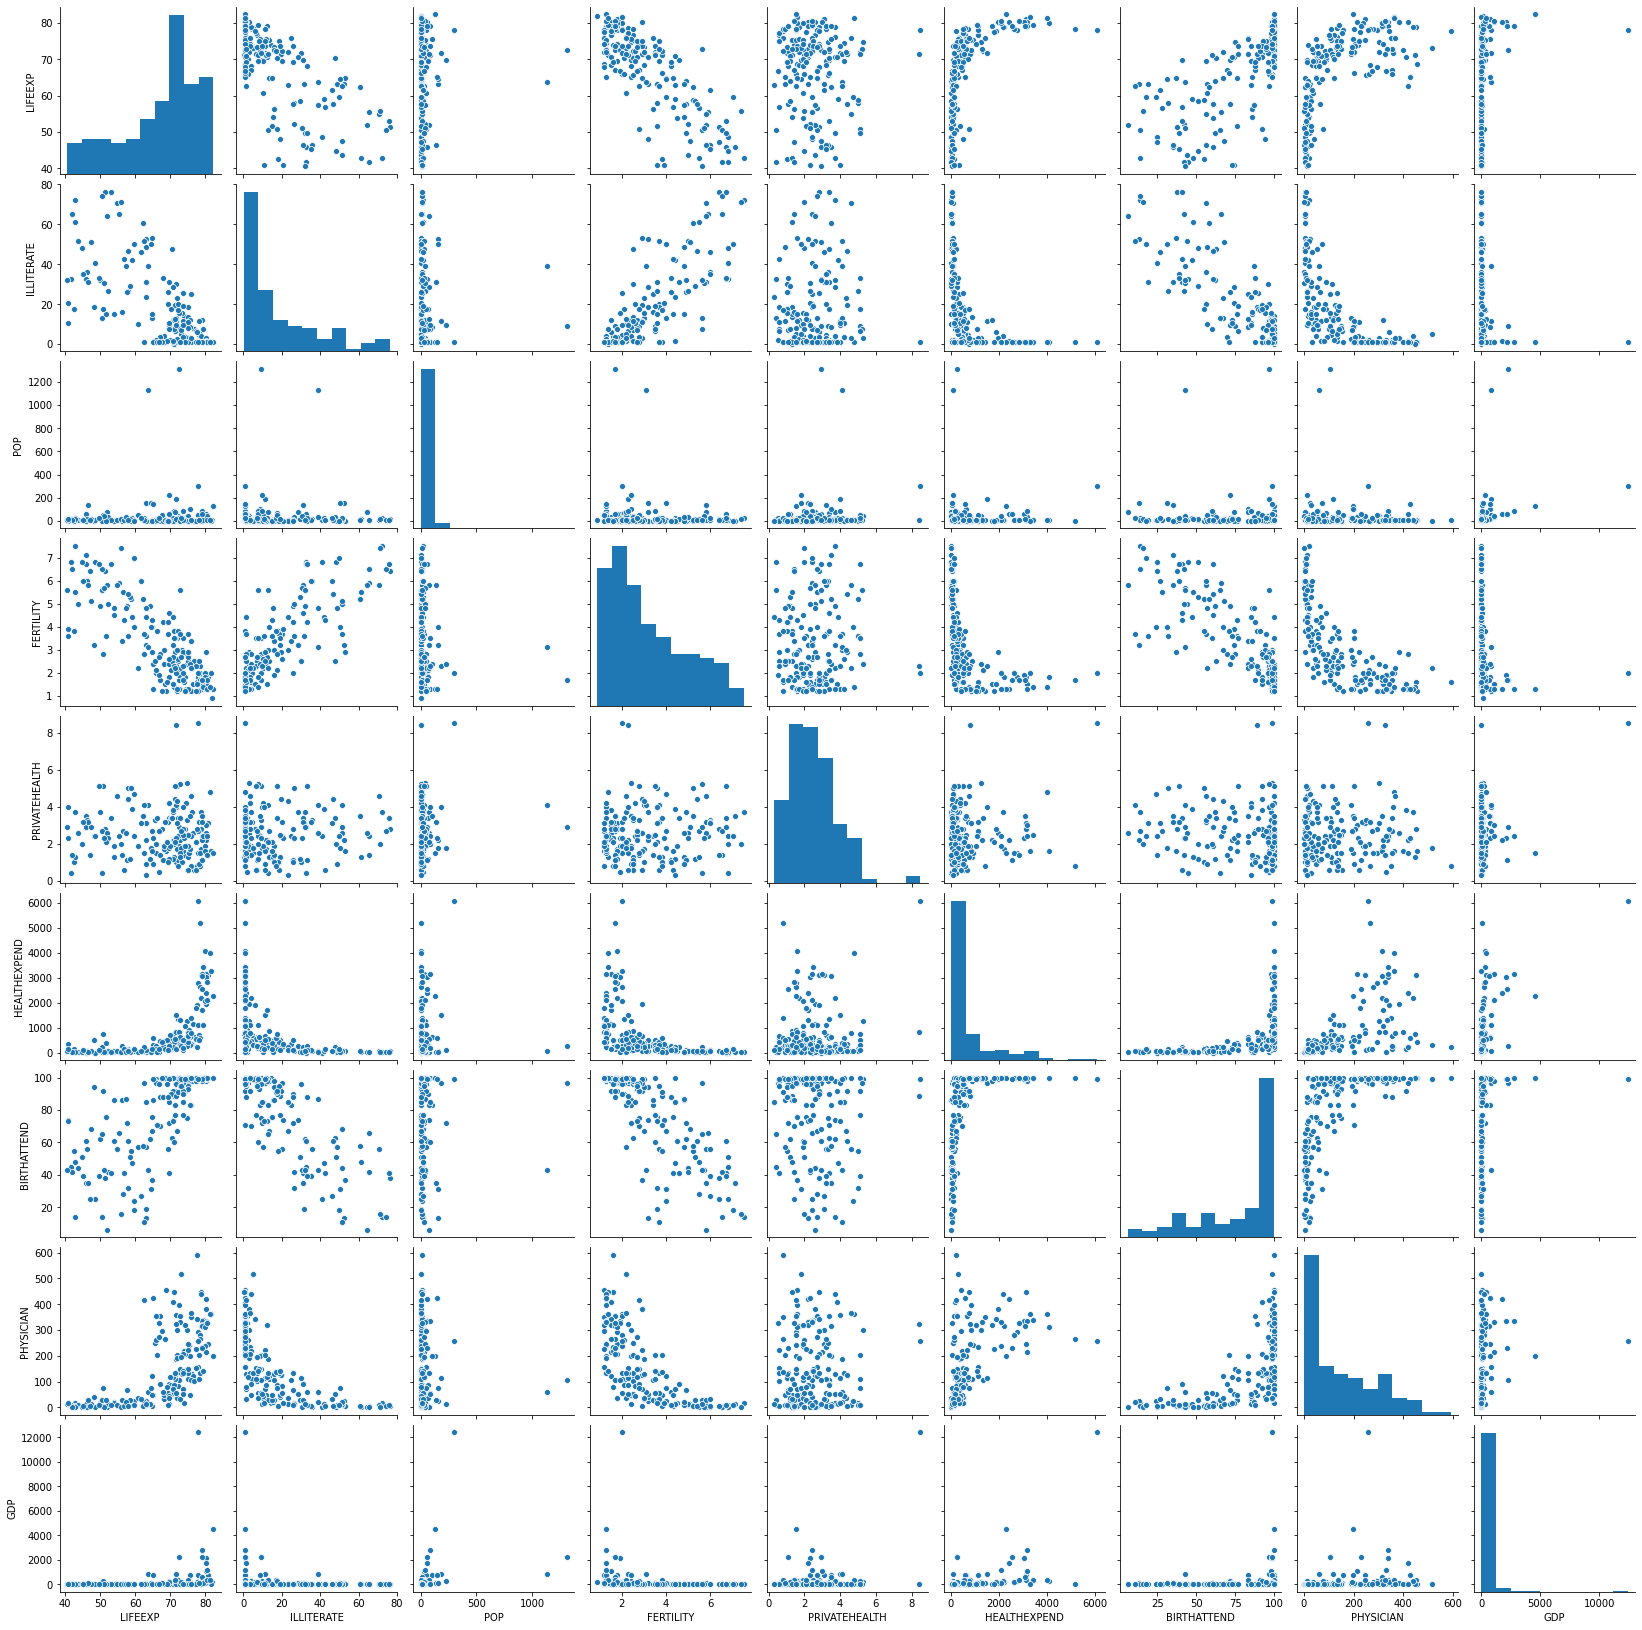

In [5]:
sns.pairplot(df)

cмотрим на кореляцию:

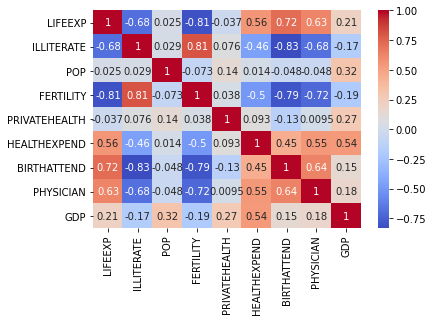

In [6]:
cor = df.corr()
sns.heatmap(cor, cmap='coolwarm', annot=True)

видим что кореляция регрессора LOS с таргетом  = 0.62, а остальных не большая  
особой кореляции между регрессорами нет  
Попробуем регрессию:

In [7]:
linear = LinearRegression()
linear.fit(X_train, y_train)
print(f'ОНК: {np.concatenate((linear.intercept_, linear.coef_.flatten()))}')
y_pred = linear.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Коефіцієнт детермінації: {r2}')
print(f'Середньоквадратична похибка: {mse}')
residuals = y_test - y_pred
var = np.var(residuals**2).values
print(f'Дисперсія: {var}')

ОНК: [ 6.93369071e+01  2.80766071e-02 -8.87566641e-04 -3.85689428e+00
 -1.60980510e-01  2.70066437e-03  9.59761435e-02  8.64623536e-04
  1.90027362e-04]
Коефіцієнт детермінації: 0.5354726754272519
Середньоквадратична похибка: 33.354025569481685
Дисперсія: [2812.13969733]


как видим, результат неочень - коеф. детерминации не сильно большой, а дисперсии как раз дофига
посмотрим на график остатков:

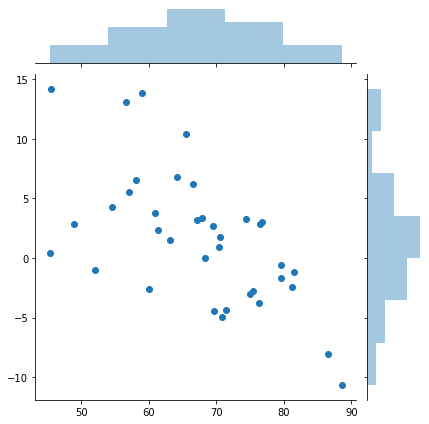

In [8]:
sns.jointplot(y_pred, residuals)

в целом ситуация неплохая, хотя остатки не очень симетричны относительно y = 0 и также присутствуют аутлаеры  
посмотрим что получиться с гребневой регрессией:

In [9]:
ridgecv = RidgeCV(alphas=[10e-1, 10e0, 10e1, 10e2, 10e3, 10e4], store_cv_values=True)
results = ridgecv.fit(X_train, y_train)
y_pred = ridgecv.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'Коефіцієнт детермінації: {r2}')
residuals = y_test - y_pred
var = np.var(residuals**2).values
print(f'Дисперсія: {var}')
print(f'Підібране значення гіперпараметру: {results.alpha_}')

Коефіцієнт детермінації: 0.5308177215679716
Дисперсія: [2591.13220876]
Підібране значення гіперпараметру: 10.0


несмотря не регуляризацию, результат ухудшился  
дальше попробуем метод главных компонент

Пояснена дисперсія: [7.90599215e-01 1.89617983e-01 1.08130024e-02 8.41586199e-03
 4.53933296e-04 9.80134183e-05 1.44024535e-06 5.50802598e-07]


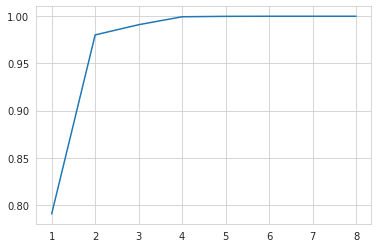

In [10]:
pca = PCA()
pca.fit(X_train)
with sns.axes_style('whitegrid'):
    sns.lineplot([1, 2, 3, 4, 5, 6, 7, 8], np.cumsum(pca.explained_variance_ratio_))
print('Пояснена дисперсія:', pca.explained_variance_ratio_)

на построеном графике кумулятивной обьясненной дисперсии видно, что хоть вторая и третья компонента немного прибавляют к объясненной дисперсии, все равно одна компонента объясняет подавляющее большинство

In [11]:
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
ridge = Ridge(alpha=10)
ridge.fit(X_train_pca, y_train)
y_pred = ridge.predict(X_test_pca)
r2 = r2_score(y_test, y_pred)
print(f'Коефіцієнт детермінації: {r2}')
residuals = y_test - y_pred
var = np.var(residuals**2).values
print(f'Дисперсія: {var}')

Коефіцієнт детермінації: 0.2729096927098733
Дисперсія: [5232.94725898]


получили не совсем ожиданный результат, коеф. детерминации = 0.097

перейдем к выбору регрессоров  
одним из более простых способов отобрать лучшие фичи - выбрать те, что корелируют с таргетом  
так и поступим:

In [12]:
cor_target = abs(cor['LIFEEXP'])
best_features = cor_target[cor_target>0.5]
best_features

LIFEEXP         1.000000
ILLITERATE      0.682143
FERTILITY       0.806747
HEALTHEXPEND    0.563772
BIRTHATTEND     0.723411
PHYSICIAN       0.633061
Name: LIFEEXP, dtype: float64

In [15]:
X_selected_train = X_train[['FERTILITY', 'HEALTHEXPEND']]
X_selected_test = X_test[['FERTILITY', 'HEALTHEXPEND']]
ridge = Ridge(alpha=10)
# ridge.fit(X_2D_train, y_train)
# print('Коефіцієнт детермінації:', ridge.score(X_2D_test, y_test))
results = ridge.fit(X_selected_train, y_train)
y_pred = ridge.predict(X_selected_test)
r2 = r2_score(y_test, y_pred)
print(f'Коефіцієнт детермінації: {r2}')
residuals = y_test - y_pred
var = np.var(residuals**2).values
print(f'Дисперсія: {var}')

Коефіцієнт детермінації: 0.5575675992589754
Дисперсія: [3091.6601842]


получили единственный регрессор TOTCHG, что и было видно из графика вначале  
следовательно, попробуем использовать наш единственный регрессор:

получили результат не намного хуже, хотя использовали всего один регрессор

в целом, модель достаточно неплохая, учитывая то, что отношения далеки от линейных

In [7]:
def make_df(N, beta0, beta1, beta2, beta3):
    x1 = np.random.normal(size=N)
    x2 = np.random.normal(size=N)
    x3 = np.random.normal(size=N)
    eps = np.random.normal(scale=0.1, size=N)
    df = pd.DataFrame(np.array([x1, x2, x3, beta0 + beta1 * x1 + beta2 * x2 + beta3 * x3 + eps]).T,
                      columns=['X1', 'X2', 'X3', 'Y'])
    return df

def OLS(X, y):
    beta = np.linalg.inv(np.dot(X.T, X)).dot(X.T).dot(y)
    return beta

def cost(theta, X, y):
    m = len(y)
    pred = X.dot(theta)
    cost = (1 / 2 * m) * np.sum(np.square(pred - y))
    return cost

def gradient_descent(X, y, theta, learning_rate=0.01, iterations=100):
    m = len(y)
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations, theta.shape[0]))
    for i in range(iterations):
        pred = np.dot(X, theta)
        theta = theta - (1 / m) * learning_rate * (X.T.dot((pred - y)))
        theta_history[i, :] = theta.T
        cost_history[i] = cost(theta, X, y)
    return theta, cost_history, theta_history

In [19]:
df = make_df(1000, 124.2, 325.1, 0.1, 0.124)
X = df[['X1', 'X2', 'X3']]
Y = df[['Y']]
theta = np.random.randn(4, 1)
X_b = np.c_[np.ones((X.shape[0], 1)), X]

In [20]:
%timeit -r 10 -n 1 OLS(X, Y)
%timeit -r 10 -n 1 gradient_descent(X_b, Y, theta)
%timeit -r 10 -n 1 LinearRegression().fit(X, Y)

The slowest run took 8.87 times longer than the fastest. This could mean that an intermediate result is being cached.
1.33 ms ± 1.48 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
245 ms ± 7.36 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
1.38 ms ± 263 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [21]:
df = make_df(100, 124.2, 325.1, 0.1, 0.124)
X = df[['X1', 'X2', 'X3']]
Y = df[['Y']]
theta = np.random.randn(4, 1)
X_b = np.c_[np.ones((X.shape[0], 1)), X]

In [22]:
%timeit -r 10 -n 1 OLS(X, Y)
%timeit -r 10 -n 1 gradient_descent(X_b, Y, theta)
%timeit -r 10 -n 1 LinearRegression().fit(X, Y)

The slowest run took 7.18 times longer than the fastest. This could mean that an intermediate result is being cached.
1.09 ms ± 1.06 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
267 ms ± 18.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
1.3 ms ± 161 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [23]:
df = make_df(100000, 124.2, 325.1, 0.1, 0.124)
X = df[['X1', 'X2', 'X3']]
Y = df[['Y']]
theta = np.random.randn(4, 1)
X_b = np.c_[np.ones((X.shape[0], 1)), X]

In [24]:
%timeit -r 10 -n 1 OLS(X, Y)
%timeit -r 10 -n 1 gradient_descent(X_b, Y, theta)
%timeit -r 10 -n 1 LinearRegression().fit(X, Y)

The slowest run took 4.12 times longer than the fastest. This could mean that an intermediate result is being cached.
7.38 ms ± 4.65 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
643 ms ± 30.7 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
14.7 ms ± 774 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)
